# **✅ 1. 라이브러리 불러오기**
딥러닝을 위한 PyTorch 및 전처리용 scikit-learn 라이브러리들을 불러옵니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# **✅ 2. 데이터 로드 및 구조 확인**
sklearn.datasets.load_digits()로 손글씨 숫자 이미지 데이터를 불러옵니다.

각 이미지는 8x8 크기의 흑백 이미지입니다.

In [2]:
# Load digits dataset
digits = datasets.load_digits()
X = digits.images  # (1797, 8, 8)
y = digits.target.reshape(-1, 1)  # (1797, 1)

In [3]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1797, 8, 8)
y shape: (1797, 1)


# ✅ **3. 이미지 정규화 및 텐서 형태 변경**
픽셀 값을 0~1 범위로 스케일링한 뒤 CNN 입력에 맞게 (N, C, H, W)로 바꿉니다.

- C=1: 흑백
- H=W=8: 8x8 이미지

In [4]:
# 정규화 (0~1 사이)
X = X / 16.0

# CNN 입력 형태로 변환 (N, 1, 8, 8)
X = X[:, np.newaxis, :, :]

In [5]:
print("정규화 후 X 평균:", np.mean(X), "표준편차:", np.std(X))

정규화 후 X 평균: 0.30526028624095713 표준편차: 0.3760492217920148


# **✅ 4. 라벨 One-hot 인코딩**
다중 클래스 분류(CrossEntropyLoss)를 위해 라벨을 one-hot 벡터로 변환합니다.

In [6]:
# One-hot 인코딩
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

In [7]:
print("One-hot 인코딩 예시:\n", y_encoded[:2])

One-hot 인코딩 예시:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


# **✅ 5. 학습용/평가용 데이터 분리**
학습 데이터를 80%, 테스트 데이터를 20%로 나눕니다.

In [8]:
# Train / Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)


In [9]:
print("학습 X:", X_train.shape)
print("테스트 X:", X_test.shape)

학습 X: (1437, 1, 8, 8)
테스트 X: (360, 1, 8, 8)


# **✅ 6. 텐서 변환 및 DataLoader 구성**
PyTorch는 numpy 배열 대신 Tensor를 사용합니다.

또한 DataLoader를 통해 미니배치 학습을 지원합니다.

In [10]:
# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# DataLoader 구성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
# 미니배치 확인
for batch_X, batch_y in train_loader:
    print("배치 X:", batch_X.shape, "배치 y:", batch_y.shape)
    break

배치 X: torch.Size([32, 1, 8, 8]) 배치 y: torch.Size([32, 10])


# **✅ 7. CNN 모델 구성**
2개의 Convolution 레이어 + Fully connected layer 구조입니다.

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (N, 16, 4, 4)
        x = self.pool(F.relu(self.conv2(x)))   # (N, 32, 2, 2)
        x = x.reshape(-1, 32 * 2 * 2)           # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = CNN()

# **✅ 8. 손실 함수와 옵티마이저 설정**
분류 문제에 적합한 CrossEntropyLoss와 Adam을 사용합니다.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# **✅ 9. 모델 학습**
20 epoch 동안 미니배치 학습을 수행하고, 각 epoch마다 손실을 출력합니다.

In [14]:
EPOCHS = 20
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        labels = torch.max(batch_y, 1)[1]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")

Epoch 1/20, Loss: 103.2419
Epoch 2/20, Loss: 96.9298
Epoch 3/20, Loss: 84.0107
Epoch 4/20, Loss: 78.0677
Epoch 5/20, Loss: 75.5413
Epoch 6/20, Loss: 74.5271
Epoch 7/20, Loss: 73.7744
Epoch 8/20, Loss: 73.3713
Epoch 9/20, Loss: 72.9945
Epoch 10/20, Loss: 72.6900
Epoch 11/20, Loss: 71.7351
Epoch 12/20, Loss: 70.0825
Epoch 13/20, Loss: 69.4345
Epoch 14/20, Loss: 69.1256
Epoch 15/20, Loss: 68.6597
Epoch 16/20, Loss: 68.4894
Epoch 17/20, Loss: 68.1094
Epoch 18/20, Loss: 67.8632
Epoch 19/20, Loss: 67.8199
Epoch 20/20, Loss: 67.6137


# **✅ 10. 예측 및 정확도 계산**
모델 평가 단계에서는 no_grad()로 그래디언트 계산을 끕니다.

In [15]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred_probs, axis=1)
    y_true_classes = torch.argmax(y_test_tensor, axis=1)  # one-hot encoding이라면
                                                          # 만약 y_test_tensor가 원-핫 인코딩이 아니라 정수 클래스라면 y_true_classes = y_test_tensor 로만 두면 됩니다.
# 정확도
acc = metrics.accuracy_score(y_true_classes, y_pred_classes)
print(f"✅ 정확도: {acc:.4f}")

✅ 정확도: 0.9750


# **✅ 11. Confusion Matrix 및 분류 리포트**
정확도 외에도 precision, recall, f1-score 등 다양한 평가 지표를 확인합니다.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.96      0.89      0.93        28
           2       0.94      1.00      0.97        33
           3       1.00      0.97      0.99        34
           4       0.98      1.00      0.99        46
           5       0.98      0.98      0.98        47
           6       0.97      1.00      0.99        35
           7       1.00      1.00      1.00        34
           8       0.93      0.90      0.92        30
           9       0.97      0.97      0.97        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



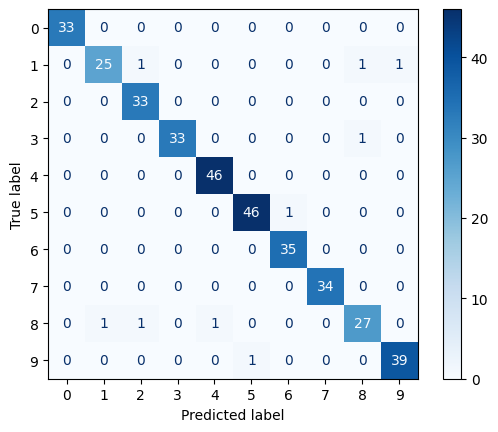

In [16]:
# 리포트 & Confusion Matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_true_classes, y_pred_classes, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, cmap='Blues')
plt.show()

# **✅ 12. 예측 이미지 시각화**
실제 숫자 이미지와 모델의 예측 결과를 같이 시각화합니다.

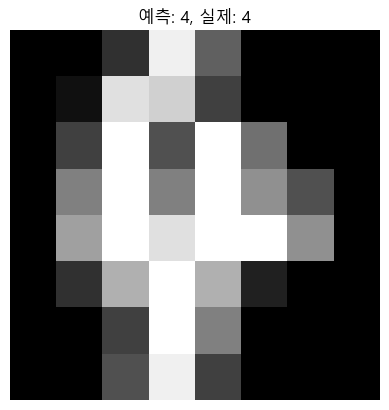

In [17]:
#한글 폰트 적용
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기준
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

idx = 12  # 예시 인덱스
plt.imshow(X_test_tensor[idx][0], cmap='gray')
plt.title(f"예측: {y_pred_classes[idx].item()}, 실제: {y_true_classes[idx].item()}")
plt.axis('off')
plt.show()